## Машинное обучение в бизнесе

## Задание

Построить обобщенную линейную модель (GLM) для прогнозирования наступления страховых случаев на рассмотренных в ноутбуке данных. Придумать и использовать дополнительные факторы при построении модели (например, пересечения признаков и т.д.). Оценить результаты построенной модели при помощи различных метрик (можно использовать и другие метрики помимо представленных в ноутбуке), выявить проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import h2o
from sklearn.model_selection import train_test_split
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import plotly.express as px
import itertools

# !pip install h2

In [111]:
!java -version

openjdk version "1.8.0_152-release"
OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12)
OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)


## Обзор датасета <left><a class="anchor" id="gen"></a><left>

In [112]:
df = pd.read_csv("freMPL-R.csv", low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

## Feature engineering <left><a class="anchor" id="gen"></a><left>

В датасете есть переменная "ClaimAmount", с отрицательными значениями. Заметим, что для этой переменной целевое значение "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [113]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


ClaimAmount  ClaimInd
82    -74.206042         0
175 -1222.585196         0
177  -316.288822         0
363  -666.758610         0
375 -1201.600604         0

In [114]:
# Обнуление отрицательных значений

df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Столбец "RecordEnd" - содержит более 50% пропусков и не обладает достаточной информативности для построения модели

In [115]:
# df.drop(['SocioCateg'], axis=1, inplace=True)
df.drop(['RecordEnd'], axis=1, inplace=True)

In [116]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [117]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

Frequency
CSP7         14
CSP3       1210
CSP1       2740
CSP2       3254
CSP4       7648
CSP6      24833
CSP5      75456

In [118]:
# one hot encoding преобразование для категорий VehUsage и SocioCateg
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [119]:
df = df.select_dtypes(exclude=['object'])

In [121]:
# Производные признаки

def get_deriv_feats(df, colname):
    df[colname + ' (^2)'] = df[colname] ** 2
    df[colname + ' (^3)'] = df[colname] ** 3
    df[colname + ' (sqrt)'] = np.sqrt(df[colname])
    df[colname + ' (log)'] = np.log(df[colname])
    df[colname + ' (/ 2)'] = df[colname] / 2
    df[colname + ' (/ 4)'] = df[colname] / 4
    return df

df = get_deriv_feats(df, 'Exposure')

# Первая производная
first_diff = np.array(df.iloc[1:,2].values - df.iloc[:-1,2].values).astype('float32') 
df['DrivAge_diff1'] = 0
df['DrivAge_diff1'] =  df['DrivAge_diff1'].astype('float') 
df['DrivAge_diff1'].values[1:] = first_diff

#  Переменная, квадрат возраста.
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)

In [122]:
df.columns

Index(['Exposure', 'LicAge', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'ClaimNbResp', 'ClaimNbNonResp',
       'ClaimNbParking', 'ClaimNbFireTheft', 'ClaimNbWindscreen', 'OutUseNb',
       'RiskArea', 'VehUsage_Private', 'VehUsage_Private+trip to office',
       'VehUsage_Professional', 'VehUsage_Professional run', 'SocioCateg_CSP1',
       'SocioCateg_CSP2', 'SocioCateg_CSP3', 'SocioCateg_CSP4',
       'SocioCateg_CSP5', 'SocioCateg_CSP6', 'SocioCateg_CSP7',
       'Exposure (^2)', 'Exposure (^3)', 'Exposure (sqrt)', 'Exposure (log)',
       'Exposure (/ 2)', 'Exposure (/ 4)', 'DrivAge_diff1', 'DrivAgeSq'],
      dtype='object')

Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [123]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [124]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

Policies
0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
11.0         1

In [125]:
fig = px.scatter(df, x='ClaimsCount', y='ClaimAmount', title='Зависимость между частотой и величиной убытков')
fig.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [126]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount

## Train test split <left><a class="anchor" id="gen"></a><left>

In [127]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(
    df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1),
    df.ClaimInd, test_size=0.3, random_state=1)

x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(
    x_train_ind, y_train_ind,
    test_size=0.5, random_state=1)

In [128]:
# Балансировка целевой переменной признаков
TARGET_NAME = 'ClaimInd'

df[TARGET_NAME].value_counts()

0    104286
1     10869
Name: ClaimInd, dtype: int64

In [129]:
def balance_df_by_target(df, target_name, balancing_type='oversampling'):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    if balancing_type == 'oversampling':
        
        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
    if balancing_type == 'undersampling':
        
        major_class_sample = df[df[target_name] == major_class_name].sample(target_counts[minor_class_name])
        minor_class_sample = df[df[target_name] == minor_class_name]
        
        df = pd.concat([major_class_sample, minor_class_sample], ignore_index=True)
        
        return df.sample(frac=1) 

In [130]:
# Балансировка признаков не улучшает качество предсказания (не используется при построении модели)

df_for_balancing = pd.concat([x_train_ind, y_train_ind], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, balancing_type='oversampling')
    
df_balanced[TARGET_NAME].value_counts()

0    72973
1    68715
Name: ClaimInd, dtype: int64

## Построение модели <left><a class="anchor" id="gen"></a><left>

In [131]:
# Инициализация пакета h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O cluster uptime:         24 mins 37 secs
H2O cluster timezone:       Europe/Moscow
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.0.3
H2O cluster version age:    4 days
H2O cluster name:           H2O_from_python_Nickel_2yh5ef
H2O cluster total nodes:    1
H2O cluster free memory:    3.177 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.1 final
--------------------------  ---------------------------------------------------------

In [132]:
# Преобразование в H2O-Frame

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [133]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train_ind['ClaimInd'] = h2o_train_ind['ClaimInd'].asfactor
h2o_valid_ind['ClaimInd'] = h2o_valid_ind['ClaimInd'].asfactor
h2o_test_ind['ClaimInd'] = h2o_test_ind['ClaimInd'].asfactor

# h2o_train_ind['ClaimInd'].asfactor
# h2o_valid_ind['ClaimInd'].asfactor
# h2o_test_ind['ClaimInd'].asfactor

In [134]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_poisson = H2OGeneralizedLinearEstimator(family = "poisson", link = "Log", nfolds=5)

glm_poisson.train(y="ClaimInd", x = h2o_train_ind.names[1:-1],training_frame = h2o_train_ind,validation_frame = h2o_valid_ind, weights_column = 'Exposure')

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [135]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, 
# Количество использованных объясняющих переменных

glm_poisson.summary()


GLM Model: summary


family link                                 regularization  \
0    poisson  log  Elastic Net (alpha = 0.5, lambda = 8.513E-5 )   

   number_of_predictors_total number_of_active_predictors  \
0                          25                          18   

   number_of_iterations  \
0                     4   

                                           training_frame  
0  Key_Frame__upload_97526b149ec1f92b50d1f74970904eb5.hex

In [136]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_poisson.cross_validation_metrics_summary().as_data_frame()

mean            sd   cv_1_valid  \
0                     mae   0.21833062   9.207294E-4   0.21809816   
1  mean_residual_deviance     0.505256   0.003028972    0.5021645   
2                     mse   0.10925414  7.3102536E-4   0.10880298   
3           null_deviance    3757.9146       40.3486    3796.2546   
4                      r2  0.023467788   0.002542826  0.025658822   
5       residual_deviance     3602.643     31.259682    3621.3726   
6                    rmse   0.33053467  0.0011044007   0.32985297   
7                   rmsle   0.23139915  7.5023476E-4   0.23087113   

    cv_2_valid  cv_3_valid   cv_4_valid   cv_5_valid  
0   0.21933095   0.2192596   0.21735275   0.21761158  
1   0.50711644   0.5094283    0.5027989   0.50477195  
2   0.10955223  0.11040867   0.10882679   0.10868002  
3    3705.0767   3726.1106    3790.1975    3771.9338  
4  0.024369666  0.02153688  0.025701597  0.020071976  
5    3557.3584   3583.2205    3619.5918     3631.672  
6   0.33098674    0.332278   0.32988906   0.32966653  
7   0.23178948  0.23253751   0.23078997   0.23100765

In [137]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

names  coefficients  standardized_coefficients
0                         Intercept     -1.888241                  -2.155948
1                            LicAge     -0.000142                  -0.022652
2                           DrivAge     -0.005540                  -0.082915
3                        HasKmLimit     -0.371211                  -0.115343
4                        BonusMalus      0.005753                   0.086740
5                          OutUseNb      0.074862                   0.050224
6                          RiskArea      0.011360                   0.025134
7                  VehUsage_Private     -0.090304                  -0.042828
8   VehUsage_Private+trip to office      0.000000                   0.000000
9             VehUsage_Professional      0.215413                   0.072274
10        VehUsage_Professional run      0.237177                   0.032161
11                  SocioCateg_CSP1     -0.097184                  -0.015070
12                  SocioCateg_CSP2     -0.225418                  -0.038375
13                  SocioCateg_CSP3      0.168348                   0.017542
14                  SocioCateg_CSP4      0.025534                   0.006455
15                  SocioCateg_CSP5      0.000000                   0.000000
16                  SocioCateg_CSP6      0.040665                   0.016929
17                  SocioCateg_CSP7     -0.144831                  -0.001418
18                    Exposure (^2)      0.000000                   0.000000
19                    Exposure (^3)      0.033777                   0.010635
20                  Exposure (sqrt)      0.000000                   0.000000
21                   Exposure (log)      0.772902                   0.433495
22                   Exposure (/ 2)      0.000000                   0.000000
23                   Exposure (/ 4)      0.000000                   0.000000
24                    DrivAge_diff1      0.000000                   0.000000
25                        DrivAgeSq      0.000029                   0.045093

In [138]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()

for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

overall        0        1        2        3  \
Intercept                       -2.15595 -2.15154 -2.15984 -2.15949 -2.15321   
LicAge                          -0.02265  0.00756 -0.04113 -0.02210 -0.02386   
DrivAge                         -0.08292 -0.08901 -0.02869 -0.06067 -0.10077   
HasKmLimit                      -0.11534 -0.10215 -0.12333 -0.10845 -0.11967   
BonusMalus                       0.08674  0.09706  0.08382  0.08539  0.08396   
OutUseNb                         0.05022  0.04879  0.04801  0.05206  0.05023   
RiskArea                         0.02513  0.01997  0.02596  0.03036  0.02639   
VehUsage_Private                -0.04283 -0.03636 -0.05134 -0.02919 -0.05396   
VehUsage_Private+trip to office  0.00000 -0.00123  0.00000  0.00000  0.00000   
VehUsage_Professional            0.07227  0.07574  0.06341  0.06971  0.06565   
VehUsage_Professional run        0.03216  0.03914  0.02934  0.02898  0.02590   
SocioCateg_CSP1                 -0.01507 -0.01202 -0.01328 -0.01053 -0.01573   
SocioCateg_CSP2                 -0.03838 -0.03091 -0.04200 -0.03394 -0.03800   
SocioCateg_CSP3                  0.01754  0.02131  0.01237  0.00347  0.03081   
SocioCateg_CSP4                  0.00646  0.00726  0.01310  0.01577  0.00858   
SocioCateg_CSP5                  0.00000  0.00000  0.00000 -0.00001  0.00000   
SocioCateg_CSP6                  0.01693  0.03192  0.01201  0.00836  0.02813   
SocioCateg_CSP7                 -0.00142 -0.00191 -0.03406  0.00439  0.00241   
Exposure (^2)                    0.00000 -0.00872 -0.00921  0.00000  0.00000   
Exposure (^3)                    0.01063  0.01576 -0.03478  0.02193  0.00685   
Exposure (sqrt)                  0.00000  0.06956  0.08890  0.04789  0.01508   
Exposure (log)                   0.43349  0.37197  0.39958  0.37997  0.41140   
Exposure (/ 2)                   0.00000 -0.00587  0.00000  0.00000  0.00000   
Exposure (/ 4)                   0.00000 -0.00587  0.00000  0.00000  0.00000   
DrivAge_diff1                    0.00000  0.00393 -0.00602  0.00784 -0.00315   
DrivAgeSq                        0.04509  0.02351  0.01534  0.01751  0.05576   

                                       4  
Intercept                       -2.15530  
LicAge                          -0.04618  
DrivAge                         -0.04076  
HasKmLimit                      -0.12246  
BonusMalus                       0.08655  
OutUseNb                         0.05124  
RiskArea                         0.02200  
VehUsage_Private                -0.04336  
VehUsage_Private+trip to office  0.00000  
VehUsage_Professional            0.08388  
VehUsage_Professional run        0.03588  
SocioCateg_CSP1                 -0.02130  
SocioCateg_CSP2                 -0.04307  
SocioCateg_CSP3                  0.01860  
SocioCateg_CSP4                 -0.00939  
SocioCateg_CSP5                  0.00379  
SocioCateg_CSP6                  0.01271  
SocioCateg_CSP7                 -0.00180  
Exposure (^2)                    0.00000  
Exposure (^3)                    0.01284  
Exposure (sqrt)                  0.02896  
Exposure (log)                   0.39987  
Exposure (/ 2)                   0.00000  
Exposure (/ 4)                   0.00000  
DrivAge_diff1                   -0.00368  
DrivAgeSq                        0.02677

In [139]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ind_train_pred = glm_poisson.predict(h2o_train_ind).as_data_frame()
ind_valid_pred = glm_poisson.predict(h2o_valid_ind).as_data_frame()
ind_test_pred = glm_poisson.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [140]:
ind_train_pred.loc[ind_train_pred['predict']>(ind_train_pred['predict'].max()/2 + ind_train_pred['predict'].min()/2), 'predict']=1
ind_train_pred.loc[ind_train_pred['predict']<(ind_train_pred['predict'].max()/2 + ind_train_pred['predict'].min()/2), 'predict']=0

ind_valid_pred.loc[ind_valid_pred['predict']>(ind_valid_pred['predict'].max()/2 + ind_valid_pred['predict'].min()/2), 'predict']=1
ind_valid_pred.loc[ind_valid_pred['predict']<(ind_valid_pred['predict'].max()/2 + ind_valid_pred['predict'].min()/2), 'predict']=0

ind_test_pred.loc[ind_test_pred['predict']>(ind_test_pred['predict'].max()/2 + ind_test_pred['predict'].min()/2), 'predict']=1
ind_test_pred.loc[ind_test_pred['predict']<(ind_test_pred['predict'].max()/2 + ind_test_pred['predict'].min()/2), 'predict']=0

## Оценка результатов работы модели <left><a class="anchor" id="gen"></a><left>

In [141]:
print('TRAIN ACCURACY: ', accuracy_score(h2o_train_ind['ClaimInd'].as_data_frame(), ind_train_pred['predict']))
print('VALID ACCURACY: ', accuracy_score(h2o_valid_ind['ClaimInd'].as_data_frame(), ind_valid_pred['predict']))
print('TEST ACCURACY: ', accuracy_score(h2o_test_ind['ClaimInd'].as_data_frame(), ind_test_pred['predict']))

TRAIN ACCURACY:  0.8928766375545851
VALID ACCURACY:  0.8921943231441049
TEST ACCURACY:  0.882517864231838


Confusion matrix, without normalization
[[35210  1309]
 [ 3426   359]]


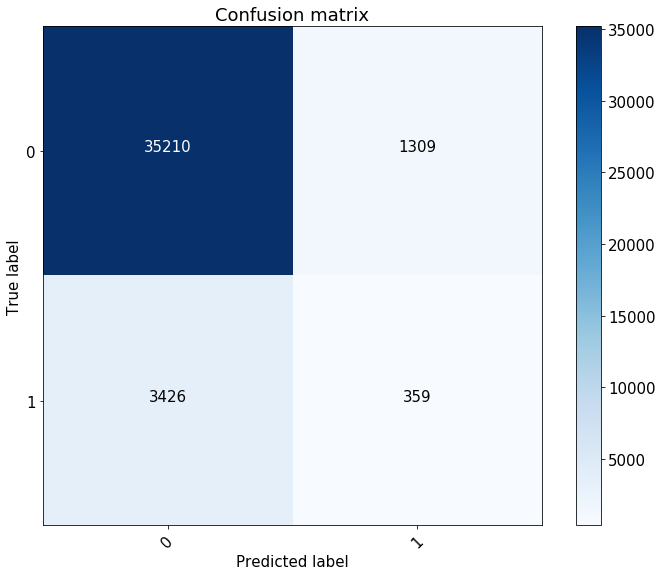

In [142]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(h2o_test_ind['ClaimInd'].as_data_frame(), ind_test_pred['predict'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
# Сохранение обученной модели

model_glm_poisson = h2o.save_model(model=glm_poisson, path="/content/drive/My Drive/Colab Notebooks/", force=True)

Проблемы модели и варианты её улучшения:

- Модель с хорошей точностью предсказывает отсутствие страхового случая, но ошибается при определении положительного события. Целевая переменная плохо несбалансирована, балансировка семплингу не дает улучшения модели. Комбинация производных признаков также не способствует значительному улучшению модели, что говорит о зашумленности данных и наличии вероятностной составляющей.

- Для улучшения качества модели можно более плотно поработать с исходными признаками, например, на предмет выбросов 